In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [27]:
customers = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')
orders['order_date'] = pd.to_datetime(orders['order_date'],infer_datetime_format=True)

In [20]:
customers.head(5)

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [21]:
orders.head(5)

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


Проверим данные на пустые значения

In [22]:
customers.isnull().sum()

id         0
name       0
segment    0
state      0
city       0
dtype: int64

In [23]:
orders.isnull().sum()

id             0
order_date     0
ship_mode      0
customer_id    0
sales          0
dtype: int64

Посмотрим на количество заказов в зависимости от даты.

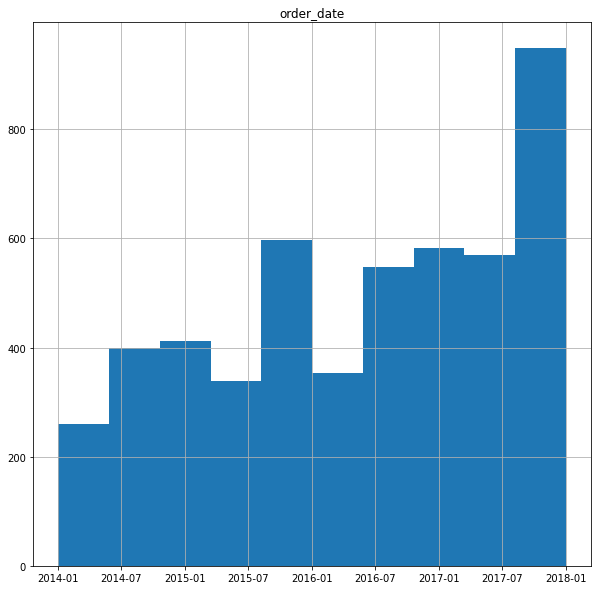

In [29]:
orders.hist('order_date', figsize=(10,10))
plt.show()

Мы видим, что количество заказов растет, но это ничего не говорит про отток пользователей - у нас просто может стать больше новых клиентов. Возьмем первый месяц заказа каждого клиента.

In [30]:
orders['order_month'] = orders['order_date'].dt.strftime('%Y-%m')
cohorts= orders.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)
cohorts.head()

,customer_id,cohort
0,AA-10315,2014-03
1,AA-10375,2014-04
2,AA-10480,2014-05
3,AA-10645,2014-06
4,AB-10015,2014-02


Из этих данных видно, что интервалы между заказами у клиентов довольно большие, из чего следует, что может оказаться довольно неинформативно смотреть на отток в случае, если клиент был неактивен, например, месяц - стоит выбрать большее окно.

In [55]:
orders['order_year'] = orders['order_date'].dt.strftime('%Y')
cohorts = orders.groupby('customer_id',as_index=False)['order_year'].min()
cohorts.groupby('order_year').count()

,customer_id
order_year,
2014,595
2015,136
2016,51
2017,11


Из данных выше видно, что новых пользователей в последние два года очень мало - предлагается в каждом новом году смотреть на старых пользователей как на новых.

Нам нужно посмотреть на 2016 и 2017 года.

In [57]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df))
    return df

In [58]:
orders_2016 = orders[orders['order_year'] == '2016']

cohorts_2016 = orders_2016.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2016.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2016 = pd.merge(orders_2016, cohorts_2016, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2016.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2016 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

In [62]:
orders_2017 = orders[orders['order_year'] == '2017']

cohorts_2017 = orders_2017.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2017.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2017 = pd.merge(orders_2017, cohorts_2017, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2017.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2017 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

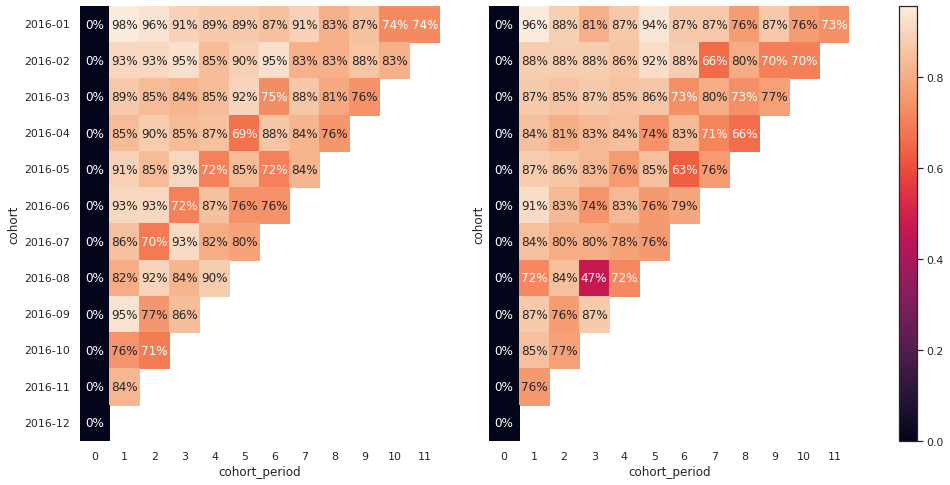

In [76]:
fig, axs = plt.subplots(ncols=3,gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(15,8))

sns.heatmap(1 - user_retention_2016.T, mask=user_retention_2016.T.isnull(), annot=True, fmt='.0%', cbar=False, ax=axs[0])
sns.heatmap(1 - user_retention_2017.T, mask=user_retention_2017.T.isnull(), annot=True, fmt='.0%', yticklabels=False, cbar=False, ax=axs[1])

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.show()

Выше у нас показатели оттока (1 - retention) по когортам в два разных года. Значимых различий не наблюдается - можно сделать вывод, что отток не изменился.

Посомтрим на различные типы доставки. Так как кроме стандартной доставки мало данных, рассмотрим отдельно стандартную доставки и все остальные вместе.

In [91]:
orders.groupby('ship_mode',as_index=False)['customer_id'].count()

,ship_mode,customer_id
0,First,787
1,Same Day,264
2,Second,964
3,Standard,2994


In [92]:
orders_2016 = orders[(orders['order_year'] == '2016') & (orders['ship_mode'] == 'Standard')]

cohorts_2016 = orders_2016.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2016.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2016 = pd.merge(orders_2016, cohorts_2016, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2016.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2016 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

orders_2017 = orders[(orders['order_year'] == '2017') & (orders['ship_mode'] == 'Standard')]

cohorts_2017 = orders_2017.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2017.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2017 = pd.merge(orders_2017, cohorts_2017, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2017.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2017 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

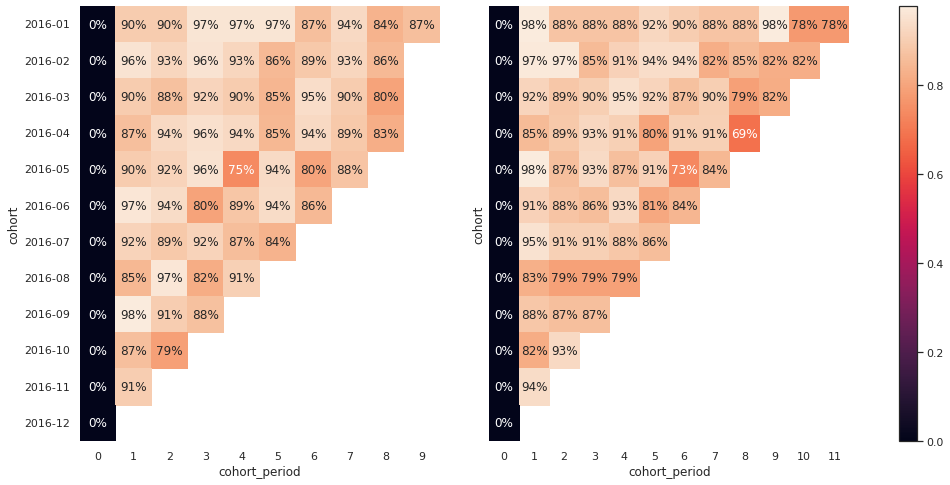

In [93]:
fig, axs = plt.subplots(ncols=3,gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(15,8))

sns.heatmap(1 - user_retention_2016.T, mask=user_retention_2016.T.isnull(), annot=True, fmt='.0%', cbar=False, ax=axs[0])
sns.heatmap(1 - user_retention_2017.T, mask=user_retention_2017.T.isnull(), annot=True, fmt='.0%', yticklabels=False, cbar=False, ax=axs[1])

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.show()

In [94]:
orders_2016 = orders[(orders['order_year'] == '2016') & ~(orders['ship_mode'] == 'Standrt')]

cohorts_2016 = orders_2016.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2016.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2016 = pd.merge(orders_2016, cohorts_2016, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2016.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2016 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

orders_2017 = orders[(orders['order_year'] == '2017') & ~(orders['ship_mode'] == 'Standrt')]

cohorts_2017 = orders_2017.groupby('customer_id',as_index=False)['order_month'].min()
cohorts_2017.rename(columns = {'order_month': 'cohort' }, inplace=True)

orders_with_cohorts_2017 = pd.merge(orders_2017, cohorts_2017, how='left', on='customer_id')

cohorts_group = orders_with_cohorts_2017.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'total_users','id_x': 'total_orders'}, inplace=True)

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True)
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
user_retention_2017 = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)

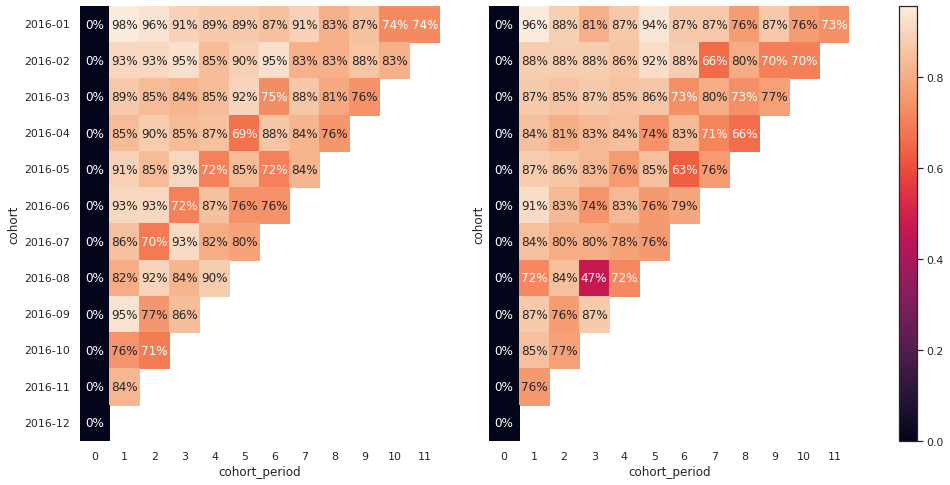

In [95]:
fig, axs = plt.subplots(ncols=3,gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(15,8))

sns.heatmap(1 - user_retention_2016.T, mask=user_retention_2016.T.isnull(), annot=True, fmt='.0%', cbar=False, ax=axs[0])
sns.heatmap(1 - user_retention_2017.T, mask=user_retention_2017.T.isnull(), annot=True, fmt='.0%', yticklabels=False, cbar=False, ax=axs[1])

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.show()

В нестандартных типах доставки заметен меньший отток в 2017 году

Посмотрим на интервалы между заказами

In [98]:
orders = orders.sort_values(['customer_id', 'order_date']).reset_index(drop=True)
orders['diff_days'] = orders.order_date.diff()
orders_interval_stat = orders[orders['diff_days'].dt.days >= 0]
orders_interval_stat.groupby('customer_id')['diff_days'].min()

customer_id
AA-10315   151 days
AA-10375    94 days
AA-10480    40 days
AA-10645    62 days
AB-10015    17 days
             ...   
XP-21865     2 days
YC-21895   147 days
YS-21880    22 days
ZC-21910     8 days
ZD-21925    32 days
Name: diff_days, Length: 784, dtype: timedelta64[ns]

In [99]:
(orders_interval_stat.groupby('customer_id')['diff_days'].min()).quantile(0.7)

Timedelta('61 days 00:00:00')

Мы видим, что интервалы между заказами довольно большие, поэтому можно было бы рассмотреть изменение количества пользователей за бОльший интервал (например, 2 месяца).